# <font color="purple">07-SahaEquations</font>

We start by importing the modules
* Numpy -- operations on arrays and matrixes (and pi)
* Matplotlib pyplot -- plotting library
* Astropy units -- defined quantities with units. We also import the CDS conversions

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
from astropy import constants as const
import astropy.units as u
from astropy.units import cds
cds.enable() 

## 0. Some functions that we will need later on.

`U = partition_H(T, smax=1)` will return the partition function for neutral hydrogen (H$^o$) for a given array of temparature $T$, truncating the summation to the energy level $s_\mathrm{max}$.

`newE, x_i = trial_saha(E, T, Ptot, X=0.75, Y=0.25)` will solve for the relative concentration $X_i$ of a given ion in a mixture of H and H, for a guessed value of $E=n_e/n_\mathrm{ion}$. It will also calculate the expected value of $E$ given the calculted $x_i$ with the help of equation #3 (in the slides) -- if it is different than the input value for $E$, it means that your guess was incorrect. 

### a. The partition function for neutral hydrogen is given by:

\begin{equation}
u(T) = \sum_{s=1}^\infty 2s^2 e^{-E_s / kT}
\end{equation}
where
\begin{equation}
E_s = 13.6 \mathrm{eV} \left( 1-\frac{1}{s^2}\right).
\end{equation}

However, because of interaction with other atoms, the sum has to be truncated to a certain maximum energy level $s_\mathrm{max}$.

In [2]:
# Function definition, accept an array of temperatures
# and an optional keyword to truncate the partition function

def partition_H(T, smax=1):
  '''Calculate the partition function for hydrogen

  Args:
      T: an array of temperatures in astropy unit.Kelvin

  Keywords:
      smax: level at which to truncate the summation (smax=1)

   Returns:
      The partition function for neutral hydrogen
  '''

  # C1 is 13.6 eV / k, in Kelvins
  C1 = 157821.462518 * u.K
    
  sum = np.zeros(T.size) # initialize the sum (as an array if necessary)
  for s in range(1,smax+1):
    sum = sum + s**2 * np.exp(C1/T/s**2)
        
  return sum*2*np.exp(-1*C1/T)

# Test the function

T = np.array([5000.0, 8000.0, 30000.0]) * u.K

print( partition_H(T, smax=1) )
print( partition_H(T, smax=50) )

[2. 2. 2.]
[  2.           2.00024106 450.48217529]


### b. A function to calculate the ionization fractions for a certain $E$.

Below, I provide a function that solve for the ion fraction 
$x_{H}^{o}, x_{H}^{+}, x_{He}^{o}, x_{He}^{+}, x_{H}^{++}$ for a given $E$, <br>
using a numpy function that solve a linear system of equation such that:<br>
$M \cdot x=b$.

The function also return the $E$ value that would correspond to this solution:<br>
$$ E = \mu_\mathrm{ion} \left[X x_{H}^{+} + \frac{Y}{4} (x_{He}^{+} + 2 x_{H}^{++} ) \right],$$
where $X$ and $Y$ are the mass fraction of H and He, respectively. 

In order to find the right solution, one must change the input value of $E$ until the function
returns the same value. 

In [3]:
# Calculate the numerical value of the constant in the equations
#print( ( 13.6 * u.eV / const.k_B ).decompose() )
#print( ( 24.5874 * u.eV / const.k_B ).decompose() ) # Ionization of He1
#print( ( 54.4177 * u.eV / const.k_B ).decompose() ) # Ionization of He2

def trial_saha(E, T, Ptot, X=0.75, Y=0.25):
    # X and Y are the mass fraction of H and He.    
        
    # Define the constants in the equations directly, to save some 
    # computation time
    CH = 157821.462518 * u.K
    CHe = 285324.957906 * u.K
    CHe2 = 631491.250064 * u.K
    # Using tabulated partition function for low smax (high pressure)
    # of course, calculations would be more complex for a 
    # self-consitent solution.
    uH0 = 2.0
    uH1 = 1.0
    uHe0 = 1.0
    uHe1 = 2.0
    uHe2 = 1.0
    
    C2 = 0.666765791503 * u.Ba / u.K**2.5
    
    # Here, we define the matrix of coefficient as shown in class. 
    # First index is the row, second index is the column.
    Coef_Mat = np.zeros((5,5))
    Coef_Mat[0,0] = -1*T**2.5 * C2 / Ptot *uH0/uH1 *np.exp(-1*CH/T)
    Coef_Mat[0,1] = E/(E+1)
    Coef_Mat[1,0] = 1.0
    Coef_Mat[1,1] = 1.0
    Coef_Mat[2,2] = -1*T**2.5 * C2 / Ptot *uHe0/uHe1 *np.exp(-1*CHe/T)
    Coef_Mat[2,3] = E/(E+1)
    Coef_Mat[3,3] = -1*T**2.5 * C2 / Ptot *uHe1/uHe2 *np.exp(-1*CHe2/T)
    Coef_Mat[3,4] = E/(E+1)
    Coef_Mat[4,2] = 1
    Coef_Mat[4,3] = 1
    Coef_Mat[4,4] = 1
    
    # Here, we define the b array
    b = np.array([0,1,0,0,1])
    
    # Using the numpy solve function, we find x such that M * x = b
    sol = np.linalg.solve(Coef_Mat,b)
    
    # Now we use solution to calculate E with our unused equation
    # If E_check is not the same as our input E, we need to change
    # our input E.
    mu_ion = 1.0/ (X+Y/4.0)
    E_check = X*sol[1] + Y/4.0*(sol[3]+2.0*sol[4]) * mu_ion

    return E_check, sol

## 1. Ionization of pure hydrogen

### a. In class: Let's create a function to calculate the Solution to Saha for pure hydrogen

We would like the function to accept an array of temperature (set in Kelvin with the astropy unit package), and return $n_{\mathrm{H}^+}/n_\mathrm{H}$.

$$K_r^{r+1}(T,P) = \frac{T^{5/2}}{P_\mathrm{gas,tot}} e^{-\chi_r/kT}\frac{U^{r+1}(T,P)}{U^r(T,P)} \left[\frac{2(2\pi m_e)^{3/2} k^{5/2}}{h^3}\right]$$

The partition function for neutral hydrogen H$^o$ can be calculated with the function `partition_H(T, smax=1)`. The partition function for H$^+$ is simply 1 (because it does not have any bound electrons) 


In [12]:
# Let's calculate the value of the constant we need
# so that the code doesn't have to recalculate it 
# every time.
print( ( 2*(2* np.pi * const.m_e)**1.5 /const.h**3 * const.k_B**2.5 ).cgs )
print( (13.6 *u.eV / const.k_B).decompose())

#---------------------------------------
#---------------------------------------
# In class

def saha_H(T, Ptot, smax=1):

  K = np.zeros(len(T))
  E = np.zeros(len(T))

  for i in range(len(T)):

    K[i] = T[i]**(5/2)/Ptot * np.exp(-(13.6 *u.eV / const.k_B).decompose() / T[i]) * 1 / partition_H(T[i], smax=1) * (2*(2* np.pi * const.m_e)**1.5 /const.h**3 * const.k_B**2.5 ).cgs

    E[i] = (K[i]/(K[i] + 1))**(1/2)

  return E

0.6667659447803991 Ba / K(5/2)
157821.4464530811 K


### b. The variation of ionization as a function of temperature

>**TODO**: In the cell below, I have already defined an array of temperatures from 1,000 to 30,000 K (using the astropy unit package). I also define a variable for a pressure of $10^4$ dyn/cm$^2$ (the name of that 'cgs' unit is a Barye, so you can use the shortcut `u.Ba`).
>
>Make a plot of the variation of $x_\mathrm{H}^+$ ($=n_\mathrm{H}^+/n_\mathrm{H}$) as a function of temperature.
>
>Next, add a curve of $x_\mathrm{H}^+$ as a function of temperature, for a different pressure (make sure to change the pressure by an amount that yields a different curve).
>
>Remember to label your axes and label your curve (look at the previous notebooks to see how)

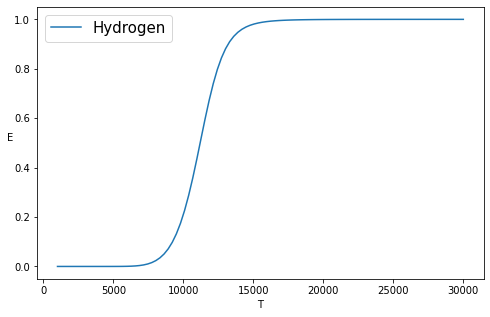

In [38]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

# Create a range of temperatures in Kelvin
rangeT = np.linspace(1000,30000,100) * u.K

# Define the pressure in dyn/cm2
Ptot = 1e4 * u.Ba

#---------------------------------------
#---------------------------------------

E = saha_H(rangeT, Ptot)

ax.set_xlabel('T')
ax.set_ylabel('E', rotation=0)

ax.plot(rangeT, E, label='Hydrogen')

ax.legend(loc=0, fontsize=15)

> **TODO**: <font color='red'>Please write a small paragraph with an interpretation of the result obtained:</font>

As the temperature of the star increases so does the value of ionized hydrogen. This is likely more probable due to the increased energy in the star and thus it is more capable of removing the electron from the proton.

## 2. Ionization of a mixture of H and He

### a. In class, demonstration of the iteration to find the right solution for $E$

(for a given temperature and pressure)

In [14]:
T = 20000.0*u.K
Ptot = 1e4 * u.Ba

#---------------------------------------
#---------------------------------------
# In class

E = 0.806
#---------------------------------------

newE, x = trial_saha(E, T, Ptot)

print( 'E: {:0.3f}, H0: {:0.3f}, H+: {:0.3f}, He0: {:0.3f}, He+: {:0.3f}, He++: {:0.3f}'.format(newE, x[0], x[1], x[2], x[3], x[4]) )

E: 0.806, H0: 0.000, H+: 1.000, He0: 0.271, He+: 0.729, He++: 0.000


### b. Mini-project: make a graph of the ionization fractions of a H and He mixture as a function of temperature

>**TODO: For a "A" on this notebook, otherwise the max grade will be "B".**
>
>Use the function described above to produce a plot of $x_{H}^{o}, x_{H}^{+}, x_{He}^{o}, x_{He}^{+}, x_{H}^{++}$ as a function of temperature, between 1000 K and 60,000 K.
>
>Let's assume that $P_\mathrm{gas, tot} = 10^{4}$ dyn/cm$^2$, $X=0.75$, and $Y=0.25$.
>
>Although this can be done by manually finding the right value of $E$ for each temperature considered (i.e. writing it down for a large number of temperatures, and then making a plot from these values), I encourage you to think on how the use of loops, arrays, and nicely formatted output to compare the $E$ values, as it may save you a lot of time.
>
>An additional note: if you decide to use some code to automatically find the right value of $E$, you should known that using a condition like a == b is very strict and might be difficult to achive, as the two floating point numbers need to be exactly the same down to the computer's numerical precision. In practice, it is sometime useful to use a condition where |a-b| < a small tolerance value that is appropriate to the current problem. 

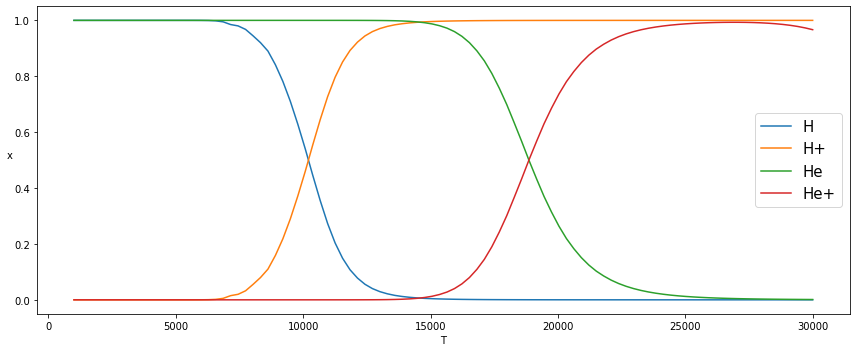

In [35]:
from typing import ItemsView
Ptot = 1e4 * u.Ba
# Don't forget to define your temperature in Kelvin using * u.K.


#---------------------------------------
#---------------------------------------
# At home

E = np.zeros(len(rangeT))
H = np.zeros(len(rangeT))
H1 = np.zeros(len(rangeT))
He = np.zeros(len(rangeT))
He1 = np.zeros(len(rangeT))

for i in range(len(rangeT)):

  newE, x = trial_saha(E[i], rangeT[i], Ptot)
  comp = abs(E[i] - newE)

  while (comp > 0.01) :

    E[i] += 0.01
    newE, x = trial_saha(E[i], rangeT[i], Ptot)
    comp = abs(E[i] - newE)

  H[i] = x[0]
  H1[i] = x[1]
  He[i] = x[2]
  He1[i] = x[3]

fig, ax = plt.subplots(1,1, figsize=(12,5))

ax.plot(rangeT, H, label='H')
ax.plot(rangeT, H1, label='H+')
ax.plot(rangeT, He, label='He')
ax.plot(rangeT, He1, label='He+')


ax.legend(loc=0, fontsize=15)
ax.set_xlabel('T')
ax.set_ylabel('x', rotation=0)
plt.tight_layout()

> **TODO**: <font color='red'>Please write a small paragraph with an interpretation of the result obtained:</font>

The values for the ionized and the nuetral atoms decrease proportionally as expected. The higher the temperature goes, the more ionized the atoms in the star become. Hydrogen does this at a lower temperature than Helium. There is also a slight dip at the highest end of the temperature in the values for ionized helium, but we would need more values of temperature to confirm if this continues. This is in line with what we discovered earlier with the values for E in hydrogen.